# 2018年度DigitalTwin操船プロジェクト
---

## 2017年度にやったこと
- 実際のVDRデータを用いて、KTモデルのシステム同定を行い、舵角・船速度を既知とした条件下である程度は航跡の予想ができることを示した
  - 詳細はJASNAOE2018講演論文を参考のこと

## 2018年度に実施したいこと

- 自律船でどのようにこの技術を使うべきかの検討
  - 自分の船 : 環境変化に対応したやり方が必要 (ベイズアプローチの導入、より詳細な運動モデル(MMGなど)の導入、など)
  - 相手の船 : AISデータは取得可能(舵角などは取得できない？)な中で、相手船がどの程度動きそうかの把握が必要


- 操船している環境によって操縦性モデルのパラメータはどのように変わるのかの検討
  - 実際のVDRデータを調査する
  - 舵角によるクラスタリング、船速によるクラスタリング、海域によるクラスタリングなど
  - 手法は最小二乗法で良いですが、どの程度ばらつきがあるかなども調査したいです


- データ同化技術の再検討
  - 2017年度は単に最小二乗法を採用していたが、他の方法もあるので調査が必要（購入したい本があれば要望を出すこと）
---

### 解析プログラムサンプル1
- 操縦シミュレーションのログを入力として、操縦性パラメータの推定を行うプログラム
- ship_mmgからの出力であるCSVファイルを入力としている
  - プログラム中ではlog_fileという変数でファイルパスを指定する
- 実データから同じ形式のCSVファイルを作成すれば同じ解析を行える
- システム同定(最小二乗法)の詳細については、import元のdt_kt.pyを参照のこと

In [1]:
%matplotlib inline
import dt_kt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from ship_mmg import kt_maneuver as kt

In [2]:
#  解析条件を設定する(ここらあたりは自分の環境によって変更するところ)
log_file = 'result.csv'
sampling = 1000 # ここはship_mmgの設定と合わせないといけないところ(たぶん... )

In [3]:
## 1. Realデータ読み込みと前処理 (今回は、ship_mmgの可視化ビューからの出力csvを想定)
csv = pd.read_csv(log_file)
csv["r_rad"] = csv["r_degree"] * np.pi / 180
csv["RudderAngle_rad"] = csv["RudderAngle_degree"] * np.pi / 180

In [4]:
# 2. システム同定(KとTから算出)
K,T = dt_kt.estimate_kt_derivatives_by_l2method(csv)
print(K,T)

0.1526477197302615 79.31772360369393


In [5]:
# 3. システム同定結果からVirtualデータの作成
x0 = csv["X"].values[0]
y0 = csv["Y"].values[0]
psi0 = csv["HDG_degree"].values[0] * np.pi / 180
u_list = csv["u"].tolist()
r0 = csv["r_rad"].values[0]
duration = csv["Time"].tail(1).values[0]
delta_list = csv["RudderAngle_rad"].tolist()

time, X = kt.maneuver(K,T,x0,y0,psi0,u_list,r0,duration,sampling,delta_list)

Text(0,0.5,'Y[m]')

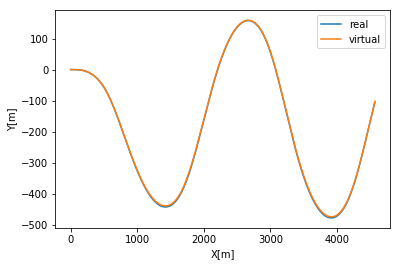

In [6]:
# 4. 結果の比較

# 4-1. 航跡
p_virtual = [X.T[1].tolist(), X.T[2].tolist()]
p_real = [csv["X"].tolist(), csv["Y"].tolist()]

#  表示
plt.plot(p_real[0], p_real[1], label='real') # ここだと、ship_mmgのログ
plt.plot(p_virtual[0], p_virtual[1], label='virtual') # ここだと、ship_mmgのログから推定したパラメータを使ってシミュレーションしたもの
plt.legend()
plt.xlabel('X[m]')
plt.ylabel('Y[m]')

Text(0.5,0,'Time[s]')

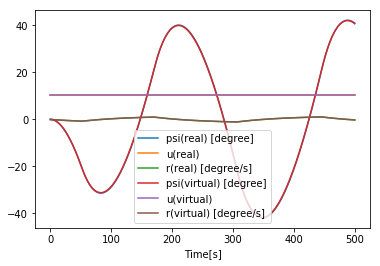

In [7]:
# 4-2. 各種値の時系列変化
value_list = [
    # csv["RudderAngle"],
    csv["HDG_degree"],
    csv["u"],
    csv["r_degree"],
    # X.T[0] * 180 / np.pi,
    X.T[3] * 180 / np.pi,
    X.T[4],
     X.T[5] * 180 / np.pi
]
label_list = [
    # "delta(real)",
    "psi(real) [degree]",
    "u(real)",
    "r(real) [degree/s]",
    # "delta(virtual)",
    "psi(virtual) [degree]",
    "u(virtual)",
    "r(virtual) [degree/s]"
]

for num in range(len(value_list)):
    plt.plot(time, value_list[num], label=label_list[num])
plt.legend()
plt.xlabel('Time[s]')

### 解析プログラムサンプル2
- 頂いたVDRデータをsqlite3形式にまとめたファイルにアクセスするプログラム

In [12]:
import db
db_file = 'data.sqlite3'

In [27]:
# より高度な解析をするために、対象の時刻部分をpandas形式で抽出
db.extract_data_as_pandas(db_file,'vdr','*','2016-11-02 00:00:00','2016-11-03 00:00:00')

SELECT * FROM vdr WHERE '2016-11-03 00:00:00' >= Time and '2016-11-02 00:00:00' <= Time
data.sqlite3


,,Time,Altitude,Geoidal,Lat,Lon,Course_over_ground,Speed_over_ground,status_water_speed,HDG,...,Rel_Wind_Spd,RudderAngle,Override,RudderOrder,SteeringMode,Depth,Engine Speed/revolutions,Engine,True_Wind_Dir,True_Wind_Spd
0,0,2016-11-02 00:00:01,47.0,46.0,53.753867,5.948188,253.3,14.0,13.34,255.8,...,NaN,-5.5,V,-5.2,S,15.2,49.5,0,NaN,NaN
1,1790,2016-11-02 00:00:02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,255.8,...,20.7,NaN,V,-4.8,S,NaN,49.7,0,NaN,NaN
2,1,2016-11-02 00:00:03,47.0,46.0,53.753828,5.947978,253.2,14.0,13.34,255.8,...,NaN,-4.8,V,-5.4,S,15.5,49.6,0,NaN,NaN
3,2,2016-11-02 00:00:04,47.0,46.0,53.753808,5.947873,253.1,14.0,13.33,255.8,...,20.3,-5.1,V,-5.4,S,15.5,49.5,0,-71.272865,14.007602
4,3,2016-11-02 00:00:05,47.0,46.0,53.753787,5.947770,252.9,14.0,13.33,255.9,...,20.9,-5.5,V,-5.8,S,15.4,49.8,0,-67.377764,14.847287
5,4,2016-11-02 00:00:06,47.0,46.0,53.753767,5.947668,252.8,14.0,13.34,255.9,...,NaN,-5.9,V,-6.1,S,15.1,50.1,0,NaN,NaN
6,5,2016-11-02 00:00:07,47.0,46.0,53.753747,5.947565,252.8,14.0,13.35,255.9,...,NaN,-6.0,V,-6.1,S,15.1,50.6,0,NaN,NaN
7,6,2016-11-02 00:00:08,47.0,46.0,53.753727,5.947460,252.9,14.0,13.36,255.9,...,21.2,-6.1,V,-6.3,S,15.2,50.2,0,-66.265172,15.221123
8,7,2016-11-02 00:00:09,47.0,46.0,53.753710,5.947355,253.1,14.0,13.37,255.8,...,20.1,-6.3,V,-6.8,S,15.3,49.6,0,-62.746089,14.296423
9,8,2016-11-02 00:00:10,47.0,46.0,53.753692,5.947250,253.1,14.0,13.38,255.7,...,NaN,-6.5,V,-6.8,S,15.2,49.8,0,NaN,NaN


In [28]:
# どの航路を走っているのかの可視化(Google Earthで可視化するためのkmlファイルを作成している)
db.make_kml_line(db_file,'vdr','2015-10-31 00:00:00','','ship_trajectory_plot.kml')

SELECT "Lat","Lon","Time" FROM vdr WHERE '2015-10-31 00:00:00' <= Time and Time LIKE '%%%%-%%-%% %%:%%:00' ORDER BY Time


SELECT "Time","HDG","Course_over_ground" FROM vdr WHERE '2016-11-10 03:00:00' >= Time and '2016-10-31 00:00:00' <= Time
data.sqlite3
Save picture to "test.png"


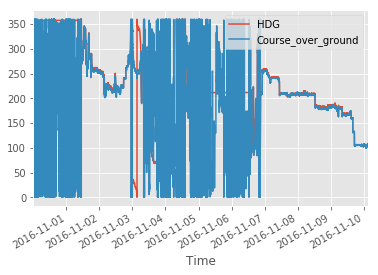

In [29]:
# 特定のcolumnの情報を可視化
db.plot_graph_from_db(db_file,'vdr','HDG,Course_over_ground','2016-10-31 00:00:00','2016-11-10 03:00:00','test.png')

SELECT "Engine Speed/revolutions","status_water_speed" FROM vdr WHERE '2016-11-06 20:38:00' >= Time and '2016-11-06 20:34:00' <= Time
data.sqlite3
Save picture to "test.png"


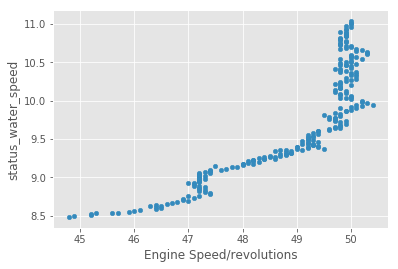

In [30]:
# 2つのデータの関係性をxy平面にプロットする
db.plot_xy_graph_from_db(db_file,'vdr','Engine Speed/revolutions','status_water_speed','2016-11-06 20:34:00','2016-11-06 20:38:00','test.png')

In [13]:
# columnのヒストグラム情報を出力(binsの設定は丁寧にしないと、合計が1.0にならないという糞仕様なので注意)
db.plot_hist_from_db(db_file,'vdr','Speed_over_ground','2016-11-06 20:19:30','2016-11-06 20:33:26','hist.png', bins=5)

SELECT "Speed_over_ground" FROM vdr WHERE '2016-11-06 20:33:26' >= Time and '2016-11-06 20:19:30' <= Time
data.sqlite3
Save picture to "hist.png"
